# Finding Donors for *CharityML*

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [2]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income']==">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income']=="<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)/n_records*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
For this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

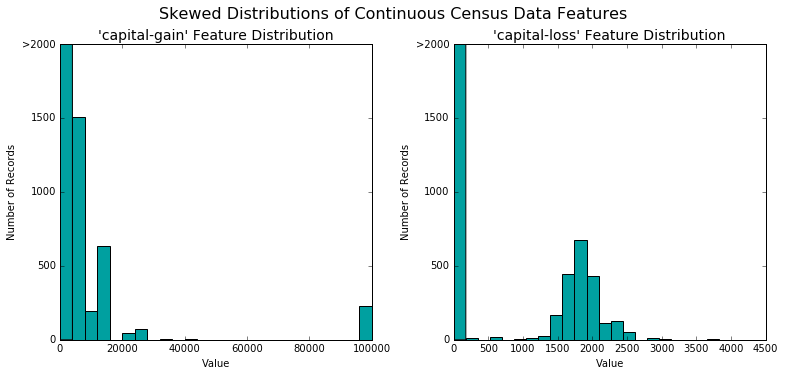

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

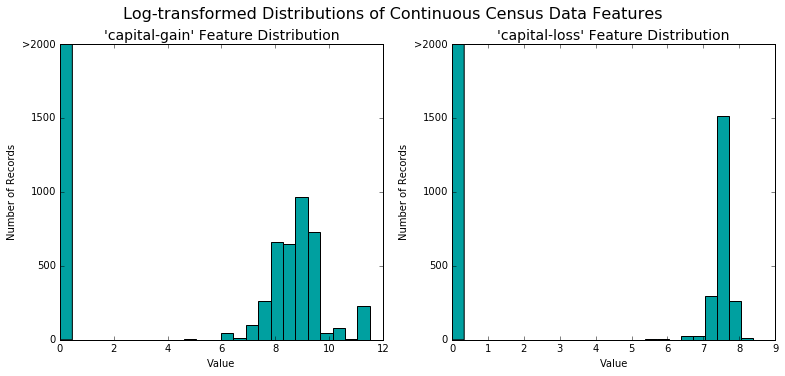

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

 - Encode categorical variables using one hot encoding
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = income_raw.replace({'<=50K': 0,'>50K': 1})

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners and the fourth algorithm is a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Naive Predictor Performace


In [8]:
# Calculate accuracy
accuracy = float(n_greater_50k)/n_records
precision=accuracy
recall=1
# Calculate F-score using the formula above for beta = 0.5
fscore = (1+0.5**2)*(precision*recall)/(((0.5**2)*precision)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

Our test data set has 36177 data points with 103 features. 5 out of 103 features are numerical while others are one hot encoded categorical features.

I pick following models to test on the census data.
- Random Forest
- Gradient Boosting
- Logistic Regression

**Random Forest: **

Application: Image classification

 - P. Du, A. Samat, B. Waske, S. Liu, Z. Li "Random forest and rotation forest for fully polarized SAR image classification using polarimetric and spatial features" ISPRS J. Photogramm. Remote Sens., 105 (2015), pp. 38-53

 - C Xie, J Dong, F Sun, L Bing, "Object-Oriented Random Forest Classification for Enteromorpha Prolifera Detection with SAR Images” 2016 International Conference on Virtual Reality and Visualization (ICVRV).

Strengths: 
 - Can be used in data sets with large number of features and instances.
 - Fast due to parallel tree generation.
 - Low variance compared to single decision tree due to uncorrelated trees.

Weaknesses: 
 - Prediction time can be higher for complex models with large number of trees.
 - Possible issues with diagonal decision boundaries

What makes this model a good candidate: Given large number of training data (36177) and one hot encoded categorical features (98) this will be a good fit for the given problem.

**Gradient Boosting: **

Application: Smart City Mobility Management Application, Tracking applications

 - Semanjski, I.; Gautama, S.	Smart City Mobility Application—Gradient Boosting Trees for Mobility Prediction and Analysis Based on Crowd sourced Data. Sensors 2015, 15, 15974-15987.

 - J. Son, I. Jung, K. Park, B. Han, "Tracking-by-segmentation with online gradient boosting decision tree", ICCV, 2015.

Strengths: 
 - Since Gradient boosting works on gradually decreasing the error for each tree it provides better accuracy with smaller number of trees.
 - Natural handling of data of mixed type (heterogeneous features).
 - Robustness to outliers in output space (via robust loss functions)

Weaknesses: 
 - More hyper parameters to tune compared to random forests.
 - Slower due to sequential tree generation and can hardly be parallelized.

What makes this model a good candidate: Given large number of training data (36177) and proven better performance compared to many other classification algorithms in variety of applications Gradient Boosting will be a good fit for this dataset.


**Logistic Regression: **

Application:

J.-Y. Kung, C.-C. Wu, S.-Y. Hsu, S.-S. W. Lee and C.-W. Yang, "Application of logistic regression analysis of home mortgage loan prepayment and default risk" ICIC EXPRESS LETTERS, VOL.4, NO.2, 2010

Strengths: 
 - Generalize well due to single decision boundary.
 - Fast compared to gradient boosting and random forests

Weaknesses: 
 - Cannot predict continuous outcomes.
 - Require adequate number of samples for each combination of independent variables.
 - High bias

What makes this model a good candidate: Given large number of training data (36177) and fast training and predicting times compared to gradient boosting and random forests this model will be a good fit for this application.

References for Pros and Cons.

 - https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons
 - http://rstudio-pubs-static.s3.amazonaws.com/4239_fcb292ade17648b097a9806fbe026e74.html
 - https://bmcproc.biomedcentral.com/articles/10.1186/1753-6561-5-S3-S11
 - https://www.researchgate.net/post/What_are_pros_and_cons_of_decision_tree_versus_other_classifier_as_KNN_SVM_NN

### Implementation - Creating a Training and Predicting Pipeline
We will implement the following pipeline:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
Now we will need to implement the following:
- Import the three supervised learning models discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model, if provided.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


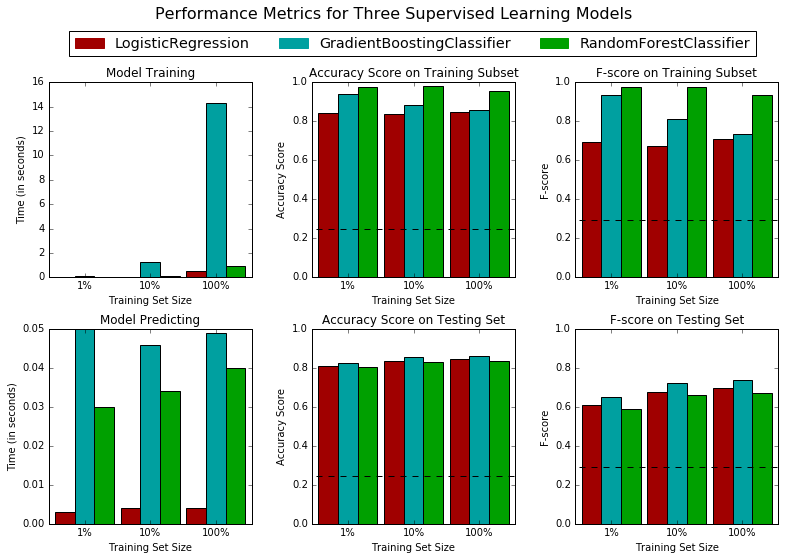

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Initialize the three models
clf_A = RandomForestClassifier(random_state=0)
clf_B = GradientBoostingClassifier(random_state=0)
clf_C = LogisticRegression(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(X_train.index)/100
samples_10 = len(X_train.index)/10
samples_100 = len(X_train.index)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose one supervised learning model and perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) to improve the untuned model's F-score. 

The performance matrices plotted above for the three selected supervised learning models contains training and prediction time, accuracy and f-score for the training subset and testing set. It can be seen that the GradientBoostingClassifier takes 10x more time to train compared to the other two models. This is due to the sequential generation of the trees. Accuracy and f-score of the tree ensemble classifiers are high for the training subset compared to the testing set due to the overfitting of the data. For GradientBoostingClassifier the accuracy and f-score of training set decrease with increasing number of training samples resulting in a better generalized model. This can be further seen by the increasing accuracy and f-score in testing set results with increasing number of training data points.
GradientBoostingClassifier scores higher than the other two classifiers in both accuracy and f-score for testing data. Even though GradientBoostingClassifier takes more time to train and predict compared to the other two classifiers it is still at an accepted level of ~14s for training and ~0.07s for prediction. Considering its higher accuracy and f-score and acceptable training and testing times, GradientBoostingClassifier will be the most appropriate choice among these three classifiers.

GradientBoostingClassifier is a boosting classifier. Boosting classifiers in general works by iteratively generating multiple weak classifiers and combining them to create a strong classifier. In gradient boosting each weak classifier is a regression tree trained to predict error of the previous classifier. Initially the classifier is set to output a constant value, and its error is calculated for each data point. Next step is to iteratively generate week regression trees to predict the error term of the previous classifier (combination of trees and initial constant value). Each tree divides the feature space in to disjoint regions and assign an error values to those regions. Full classifier is the sum of the results from each regression tree and initial constant value.

Following is an example of a model with three regression trees.

<img src="model3.png">

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.2)

# Create the parameters list you wish to tune
parameters = {'min_samples_leaf': [5,10],'n_estimators':[50,100,200] }

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8668
F-score on testing data: 0.7455

Optimized Model
------
Final accuracy score on the testing data: 0.8705
Final F-score on the testing data: 0.7523


#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |     0.8668        |   0.8705        |
| F-score        |      0.2917         |     0.7455        |   0.7523        |


Compared to the Benchmark Predictor, Optimized Model has a great improvement in both Accuracy (0.2478 -> 0.8668) and F-Score (0.2917 -> 0.7455). After the parameter optimization it is found that setting minimum samples per leaf as 5 and number of estimators as 200 further improves both Accuracy and F-score to 0.8705 and 0.7523 respectively.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000. We will rank the features using feature_importance_attribute of a supervised learning algorithm.

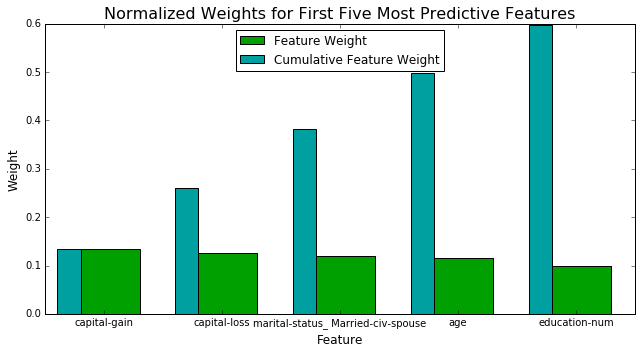

In [12]:
# Using a supervised learning model that has 'feature_importances_'

# rain the supervised model on the training set 
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Capital loss can be seen as an important feature here due to the same reason as capital gain is an important feature. Married with civilian spouse might have led to an increased household income, compared to a single unmarried or separated individual income. Also occupation might not have been selected to be among top 5 features due to its one hot encoding, making the individual one hot encoded occupation columns less effective in predicting the output compared with capital loss or "marital status - Married-civ-spouse" features.

### Feature Selection
From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8705
F-score on testing data: 0.7523

Final Model trained on reduced data
------
Accuracy on testing data: 0.8584
F-score on testing data: 0.7246


Using reduced features we were able to achieve accuracy of 0.8545 which is comparative to the model trained with all the features (0.8705). F-score value is also remained high (0.7246) after feature reduction. High accuracy and F-score obtained by model trained with reduced features suggests that feature reduction is a great way to reduce the training time for this data set without adversely affecting its accuracy and f-score. If the training time was a factor I would consider using reduced data as my training set.